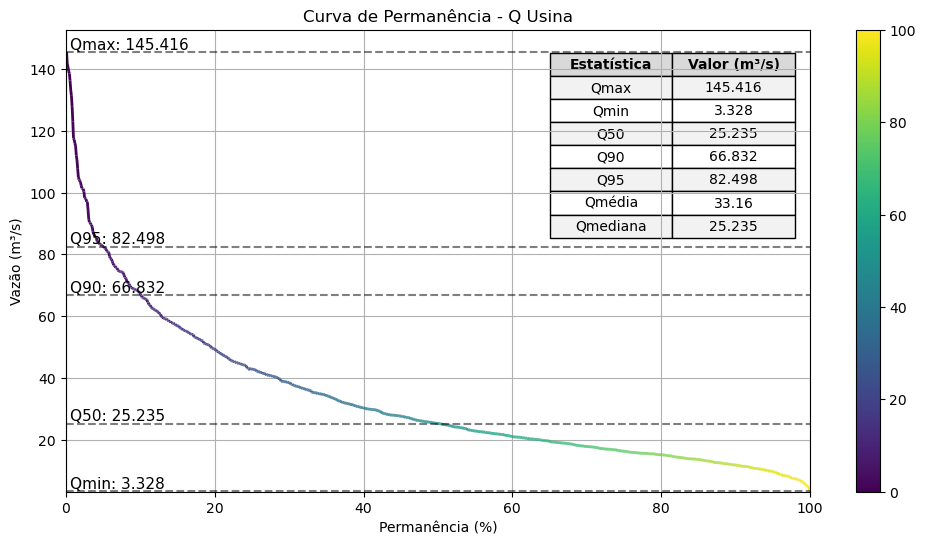

Arquivo comparativo criado: Analises/Comparativo_Vazao.xlsx


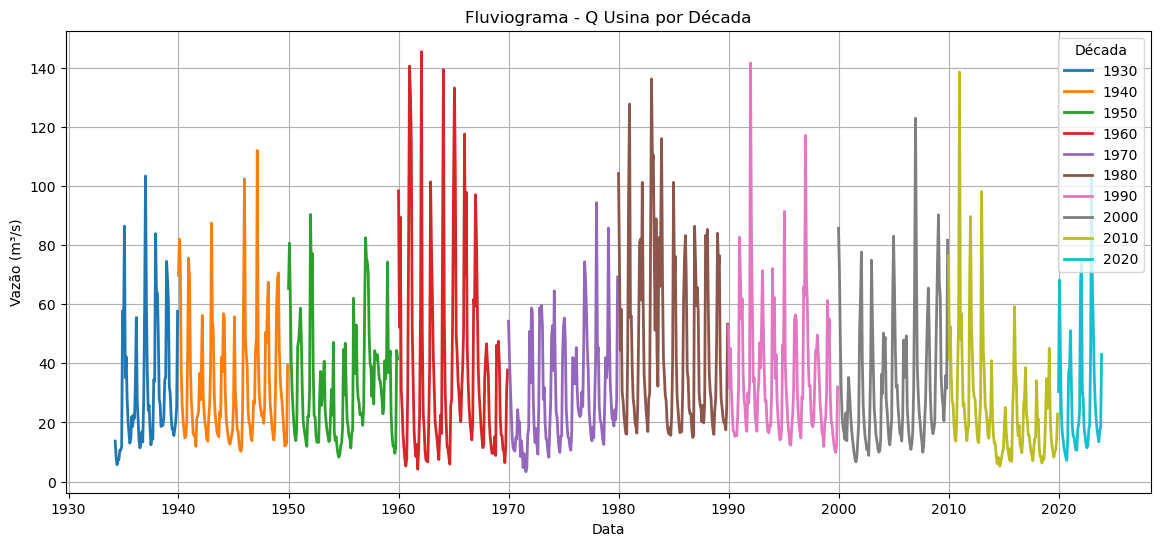

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import os

# -----------------------------
# Configurações iniciais
# -----------------------------
epsilon_log = 1e-6  # para estabilidade no log1p
os.makedirs("Graficos", exist_ok=True)
os.makedirs("Analises", exist_ok=True)

# -----------------------------
# Ler planilha
# -----------------------------
caminho_arquivo = "Cálculo da PCH-SOLAR.xlsx"
aba_escolhida = "Curva de Permanência"

df = pd.read_excel(caminho_arquivo, sheet_name=aba_escolhida, header=0)
df = df.dropna(axis=1, how='all')
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df['Q usina m³ [Vazão]'] = (
    df['Q usina m³ [Vazão]']
    .astype(str)
    .str.replace(' ', '')
    .str.replace(',', '.')
)
df['Q usina m³ [Vazão]'] = pd.to_numeric(df['Q usina m³ [Vazão]'], errors='coerce')
vazao_real = df['Q usina m³ [Vazão]'].dropna().reset_index(drop=True)

# -----------------------------
# Estatísticas
# -----------------------------
estatisticas = {
    'Qmax': vazao_real.max(),
    'Qmin': vazao_real.min(),
    'Q50': np.percentile(vazao_real, 50),
    'Q90': np.percentile(vazao_real, 90),
    'Q95': np.percentile(vazao_real, 95),
    'Qmédia': vazao_real.mean(),
    'Qmediana': vazao_real.median()
}

# -----------------------------
# Curva de permanência
# -----------------------------
vazao_ord = vazao_real.sort_values(ascending=False).reset_index(drop=True)
permanencia = np.arange(1, len(vazao_ord)+1) / len(vazao_ord) * 100

segments = [[[permanencia[i], vazao_ord[i]], [permanencia[i+1], vazao_ord[i+1]]] for i in range(len(vazao_ord)-1)]
lc = LineCollection(segments, cmap='viridis', linewidths=2)
lc.set_array(np.linspace(0, 100, len(segments)))

fig, ax = plt.subplots(figsize=(12,6))
ax.add_collection(lc)
ax.set_xlim(0, 100)
ax.set_ylim(vazao_ord.min()*0.95, vazao_ord.max()*1.05)
ax.set_xlabel('Permanência (%)')
ax.set_ylabel('Vazão (m³/s)')
ax.set_title('Curva de Permanência - Q Usina')
ax.grid(True)

# Linhas de referência
for y, label in zip([estatisticas['Qmax'], estatisticas['Qmin'], estatisticas['Q50'],
                     estatisticas['Q90'], estatisticas['Q95']],
                    ['Qmax', 'Qmin', 'Q50', 'Q90', 'Q95']):
    ax.axhline(y, linestyle='--', color='black', alpha=0.5)
    ax.text(0.5, y, f'{label}: {y:.3f}', color='black', fontsize=11, va='bottom')

# Colorbar
cbar = fig.colorbar(lc, ax=ax)

# Tabela de estatísticas
df_estat = pd.DataFrame({k: [round(v,3)] for k,v in estatisticas.items()}).T.reset_index()
df_estat.columns = ['Estatística', 'Valor (m³/s)']

table = ax.table(cellText=df_estat.values,
                 colLabels=df_estat.columns,
                 cellLoc='center',
                 colLoc='center',
                 loc='upper right',
                 bbox=[0.65, 0.55, 0.33, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.2)

for i in range(len(df_estat)):
    for j in range(2):
        cell = table[i+1, j]
        cell.set_facecolor('#f2f2f2' if i%2==0 else '#ffffff')
        cell.set_edgecolor('black')

for j in range(2):
    cell = table[0, j]
    cell.set_facecolor('#d9d9d9')
    cell.set_edgecolor('black')
    cell.set_text_props(weight='bold')

plt.savefig("Graficos/Curva_Permanencia_QUsina.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# CSV comparativo
# -----------------------------
vazao_decrescente = vazao_real.sort_values(ascending=False).reset_index(drop=True)
df_comparativo = pd.DataFrame({
    'Vazao_Real (m³/s)': vazao_real,
    'Vazao_Decrescente (m³/s)': vazao_decrescente,
    'Permanencia (%)': permanencia
})
df_stats = pd.DataFrame(list(estatisticas.items()), columns=['Estatística', 'Valor (m³/s)'])

with pd.ExcelWriter("Analises/Comparativo_Vazao.xlsx") as writer:
    df_comparativo.to_excel(writer, index=False, sheet_name='Série de Vazão')
    df_stats.to_excel(writer, index=False, sheet_name='Estatísticas')

print("Arquivo comparativo criado: Analises/Comparativo_Vazao.xlsx")

# -----------------------------
# Fluviograma por décadas
# -----------------------------
df_plot = df.copy()
df_plot['Ano'] = df_plot['Data'].dt.year
df_plot['Década'] = (df_plot['Ano'] // 10) * 10

plt.figure(figsize=(14,6))
sns.lineplot(data=df_plot, x='Data', y='Q usina m³ [Vazão]', hue='Década', palette='tab10', linewidth=2)
plt.xlabel('Data')
plt.ylabel('Vazão (m³/s)')
plt.title('Fluviograma - Q Usina por Década')
plt.legend(title='Década', loc='upper right')
plt.grid(True)
plt.savefig("Graficos/Fluviograma_QUsina_Decadas.png", dpi=300, bbox_inches='tight')
plt.show()
